In [ ]:
!pip install catboost

In [ ]:
import sklearn
sklearn.__version__

'0.22.2.post1'

In [ ]:
import os
import time
import pandas as pd
import re
import numpy as np
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn import svm
from nltk.corpus import stopwords
from scipy import sparse, hstack, vstack
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import string
import itertools

In [ ]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#importing stopwords
#STOP_WORDS = stopwords.words('bengali')
stopWords = []
with open('/content/drive/MyDrive/research/bengali', 'r', encoding="utf8") as f:
    for row in f:  # iterate over the rows in the file
        row = row.replace("\n", "")
        stopWords.append(row)

In [ ]:
#striping punctuations
puncList = ["।", "”", "“", "’"]
for p in string.punctuation.lstrip():
    puncList.append(p)

In [ ]:
#word tokenizer
def tokenizer(doc):
    # remove punctuation
    tokens = []
    def cleanword(word):
        for p in puncList:
            word = word.replace(p, "")
        word = re.sub(r'[\u09E6-\u09EF]', "", word, re.DEBUG)  # replace digits

        return word

    for word in doc.split(" "):
        word = cleanword(word)
        if word != "":
            tokens.append(word)

    return tokens

In [ ]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion Matrix', cmap = plt.cm.Greens):
    plt.imshow(cm,interpolation = 'nearest',cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks,classes,rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized CM")
    else:
        print("CM not normalized")
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
#importing dataset

df = pd.read_csv("/content/drive/MyDrive/research/totaldata.csv")
#df = pd.read_csv("/content/drive/MyDrive/research/TrainTest.csv")
df = df[df["articleID"] != 27753]
consistentID = set(df["articleID"])
print(df.shape)
head = list(df)

(11434, 5)


In [ ]:
df.head()

,Unnamed: 0,articleID,content,headline,label
0,0,1,গত ১৭ সেপ্টেম্বর বাংলাদেশ কৃষি বিশ্ববিদ্যালয়ে ...,"হট্টগোল করায় বাকৃবিতে দুইজন বরখাস্ত, ৬ জনকে শোকজ",1
1,1,2,বাংলাদেশের বৃহৎ শ্রমবাজার মালয়েশিয়ায় আবার শ্রম...,মালয়েশিয়ায় কর্মী পাঠানোর ব্যবস্থা নেয়ার সুপারিশ,1
2,2,3,নরসিংদীর মনোহরদীতে প্রেমের প্রস্তাবে রাজি না হ...,প্রেমের প্রস্তাবে রাজি না হওয়ায় স্কুলছাত্রীকে ...,1
3,3,4,সুপ্রিম কোর্টের হাইকোর্ট বিভাগের বিচারপতি আহমে...,মেডিয়েশনই মামলাজট নিরসনের পথ : বিচারপতি আহমেদ ...,1
4,4,5,মাদারীপুর সদরের উপজেলার লেকেরপাড়ে একটি বেসরকার...,টকশোতে বক্তব্য দিতে গিয়ে জাপা নেতার মৃত্যু,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11434 entries, 0 to 11433
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  11434 non-null  int64 
 1   articleID   11434 non-null  int64 
 2   content     11434 non-null  object
 3   headline    11434 non-null  object
 4   label       11434 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 536.0+ KB


In [ ]:
# Create a column with all the data available
df['total']=df['headline']+' '+df['content']
df.head()

,Unnamed: 0,articleID,content,headline,label,total
0,0,1,গত ১৭ সেপ্টেম্বর বাংলাদেশ কৃষি বিশ্ববিদ্যালয়ে ...,"হট্টগোল করায় বাকৃবিতে দুইজন বরখাস্ত, ৬ জনকে শোকজ",1,"হট্টগোল করায় বাকৃবিতে দুইজন বরখাস্ত, ৬ জনকে শো..."
1,1,2,বাংলাদেশের বৃহৎ শ্রমবাজার মালয়েশিয়ায় আবার শ্রম...,মালয়েশিয়ায় কর্মী পাঠানোর ব্যবস্থা নেয়ার সুপারিশ,1,মালয়েশিয়ায় কর্মী পাঠানোর ব্যবস্থা নেয়ার সুপারি...
2,2,3,নরসিংদীর মনোহরদীতে প্রেমের প্রস্তাবে রাজি না হ...,প্রেমের প্রস্তাবে রাজি না হওয়ায় স্কুলছাত্রীকে ...,1,প্রেমের প্রস্তাবে রাজি না হওয়ায় স্কুলছাত্রীকে ...
3,3,4,সুপ্রিম কোর্টের হাইকোর্ট বিভাগের বিচারপতি আহমে...,মেডিয়েশনই মামলাজট নিরসনের পথ : বিচারপতি আহমেদ ...,1,মেডিয়েশনই মামলাজট নিরসনের পথ : বিচারপতি আহমেদ ...
4,4,5,মাদারীপুর সদরের উপজেলার লেকেরপাড়ে একটি বেসরকার...,টকশোতে বক্তব্য দিতে গিয়ে জাপা নেতার মৃত্যু,1,টকশোতে বক্তব্য দিতে গিয়ে জাপা নেতার মৃত্যু মাদ...


In [ ]:
df['label'].value_counts()

1    10000
0     1434
Name: label, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


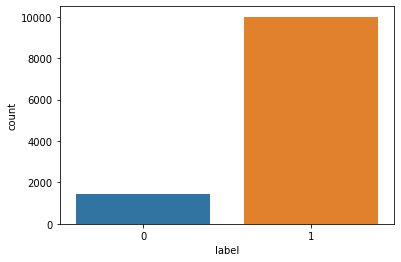

In [ ]:
sns.countplot(df['label'])

In [ ]:
data = df.content
data

0        গত ১৭ সেপ্টেম্বর বাংলাদেশ কৃষি বিশ্ববিদ্যালয়ে ...
1        বাংলাদেশের বৃহৎ শ্রমবাজার মালয়েশিয়ায় আবার শ্রম...
2        নরসিংদীর মনোহরদীতে প্রেমের প্রস্তাবে রাজি না হ...
3        সুপ্রিম কোর্টের হাইকোর্ট বিভাগের বিচারপতি আহমে...
4        মাদারীপুর সদরের উপজেলার লেকেরপাড়ে একটি বেসরকার...
                               ...                        
11429    এটিকে আর্মি অব ইসলাম বা ‘ইসলামি আর্মি’ নামে অভ...
11430    বিশ্ব মুসলিমদের প্রধান শত্রু ইহুদিবাদী সন্ত্রা...
11431    ইসলামী মূল্যবোধের উন্নয়ন এবং ইসলামী সংস্কৃতি ব...
11432    ভারতের বিনোদন জগতে গত কয়েক দিন সবচেয়ে উচ্চারিত...
11433    রোনাভাইরাসের কোনো প্রতিষেধক আবিষ্কার না হলেও এ...
Name: content, Length: 11434, dtype: object

In [ ]:
#tf-idf vectorizer
#tfidf_word = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 1),
#                                 stop_words=stopWords, decode_error='replace',
#                                 encoding='utf-8', analyzer='word', tokenizer=tokenizer)


#x_word = tfidf_word.fit_transform(data.values.astype('U'))
#outfile = open("tfidf_word_pkl", 'wb')
#pickle.dump(x_word, outfile)
#outfile.close()

In [ ]:
#tf-idf char vectorizer
tfidf_char = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(3, 3), stop_words=stopWords,
                                 decode_error='replace', encoding='utf-8', analyzer='char')

tfidf_char.fit(data.values.astype('U'))
x_char = tfidf_char.transform(data.values.astype('U'))
#outfile = open("tfidf_char_pkl", 'wb')
#pickle.dump(tfidf_char, outfile)
#outfile.close()

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:520: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'stop_words' will not be used"


In [ ]:
#tfidf_word.get_feature_names()[:10]

In [ ]:
#tfidf_word.get_params()

In [ ]:
#calling tf-idf vectorizer
#X = x_word
X = x_char
Y = df[["label"]]
print(X.shape)
print(Y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, Y.values.ravel(), test_size=0.3, random_state=109)

(11434, 30925)
(11434, 1)


## SVM with TF-IDF

Accuracy: 0.9845526085689303
Precision: 0.986737400530504
Recall: 0.9956507193041151
F1-Score: 0.9911740216486261
Confusion Matrix: [[ 402   40]
 [  13 2976]]
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       442
           1       0.99      1.00      0.99      2989

    accuracy                           0.98      3431
   macro avg       0.98      0.95      0.96      3431
weighted avg       0.98      0.98      0.98      3431

CM not normalized


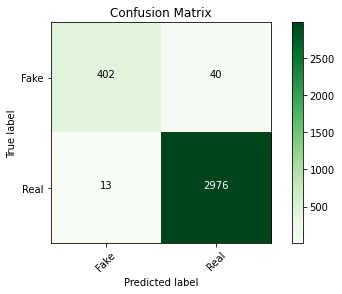

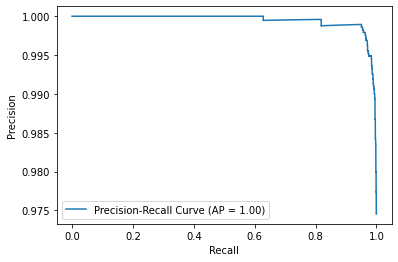

In [ ]:
# Creating SVM Classifier
start = time.time()
clf = svm.SVC(kernel='linear', C=100, cache_size=7000)

clf.fit(X_train, y_train)

#Save Model
outfile = open("model", 'wb')
pickle.dump(clf, outfile)
outfile.close()

y_pred = clf.predict(X_test)
end = time.time()
svc_time = end - start
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
svc_acc = round((100 * metrics.accuracy_score(y_test, y_pred)), 2)
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1-Score:", metrics.f1_score(y_test, y_pred))
sv_fp, sv_tp, thresh = roc_curve(y_test, y_pred)
print("Confusion Matrix:", metrics.confusion_matrix(y_test, y_pred))
cm = metrics.confusion_matrix(y_test, y_pred)
print(metrics.classification_report(y_test, y_pred))
#plot_confusion_matrix(clf, X_test, y_test, display_labels=['FAKE', 'REAL'], cmap='Greens', values_format="d")
plot_confusion_matrix(cm,classes = ['Fake','Real'])
plot_precision_recall_curve(clf, X_test, y_test, name='Precision-Recall Curve')

## LR with TF-IDF 

Accuracy: 0.9487030020402215
Precision: 0.9486443381180223
Recall: 0.9949815991970559
F1-Score: 0.9712606139777923
Confusion Matrix: [[ 281  161]
 [  15 2974]]
              precision    recall  f1-score   support

           0       0.95      0.64      0.76       442
           1       0.95      0.99      0.97      2989

    accuracy                           0.95      3431
   macro avg       0.95      0.82      0.87      3431
weighted avg       0.95      0.95      0.94      3431

CM not normalized


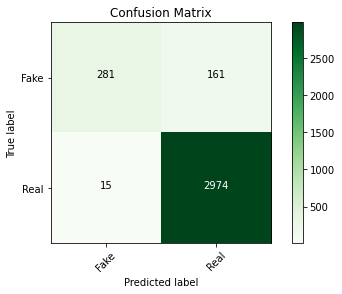

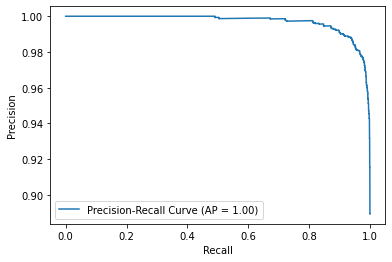

In [ ]:
# Logistic Regression
start = time.time()
lrclf = LogisticRegression()

lrclf.fit(X_train, y_train)

y_pred = lrclf.predict(X_test)
end = time.time()
lr_time = end - start
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
lr_acc = round((100 * metrics.accuracy_score(y_test, y_pred)), 2)
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1-Score:", metrics.f1_score(y_test, y_pred))
print("Confusion Matrix:", metrics.confusion_matrix(y_test, y_pred))
cm = metrics.confusion_matrix(y_test, y_pred)
print(metrics.classification_report(y_test, y_pred))
lr_fp, lr_tp, thresh = roc_curve(y_test, y_pred)
plot_confusion_matrix(cm,classes = ['Fake','Real'])
#plot_confusion_matrix(lrclf, X_test, y_test, display_labels=['FAKE', 'REAL'], cmap='Greens', values_format="d")
plot_precision_recall_curve(lrclf, X_test, y_test, name='Precision-Recall Curve')

## MNB with TF-IDF 

In [ ]:
# tune the hyperparameter alpha for the naive bayes classifier
#for alpha in np.arange(0,1,.05):
#    mnb_classifier_tune = MultinomialNB(alpha=alpha)
#    mnb_classifier_tune.fit(X_train, y_train)
#    pred_tune = mnb_classifier_tune.predict(X_test)
#    score = metrics.accuracy_score(y_test, y_pred)
#    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))

In [ ]:
# Multinomial Naive Bayes Classifier
#mnbclftune = MultinomialNB(alpha = 0.10)

#mnbclftune.fit(X_train, y_train)

#y_pred = mnbclftune.predict(X_test)
#print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
print(round((100 * metrics.accuracy_score(y_test, y_pred)), 2))

Accuracy: 0.9513261439813465
Precision: 0.9763673193787981
Recall: 0.9675476748076279
F1-Score: 0.9719374894975634
Confusion Matrix: [[ 372   70]
 [  97 2892]]
              precision    recall  f1-score   support

           0       0.79      0.84      0.82       442
           1       0.98      0.97      0.97      2989

    accuracy                           0.95      3431
   macro avg       0.88      0.90      0.89      3431
weighted avg       0.95      0.95      0.95      3431

CM not normalized


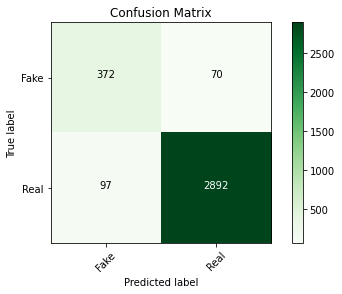

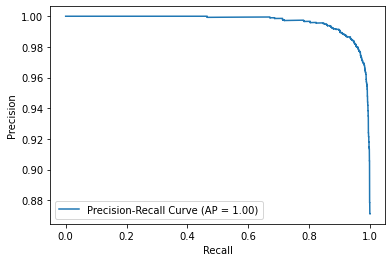

In [ ]:
# Multinomial Naive Bayes Classifier
start = time.time()
mnbclf = MultinomialNB(alpha = 0.01)

mnbclf.fit(X_train, y_train)

y_pred = mnbclf.predict(X_test)
end = time.time()
mnb_time = end - start
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
mnb_acc = round((100 * metrics.accuracy_score(y_test, y_pred)), 2)
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1-Score:", metrics.f1_score(y_test, y_pred))
print("Confusion Matrix:", metrics.confusion_matrix(y_test, y_pred))
cm = metrics.confusion_matrix(y_test, y_pred)
print(metrics.classification_report(y_test, y_pred))
mnb_fp, mnb_tp, thresh = roc_curve(y_test, y_pred)
plot_confusion_matrix(cm,classes = ['Fake','Real'])
#plot_confusion_matrix(mnbclf, X_test, y_test, display_labels=['FAKE', 'REAL'], cmap='Greens', values_format="d")
plot_precision_recall_curve(mnbclf, X_test, y_test, name='Precision-Recall Curve')

## Passive Agressive Classifier With TF-IDF Vectorizer 

Accuracy: 0.9839696881375692
Precision: 0.9860834990059643
Recall: 0.9956507193041151
F1-Score: 0.9908440153154654
Confusion Matrix: [[ 400   42]
 [  13 2976]]
              precision    recall  f1-score   support

           0       0.97      0.90      0.94       442
           1       0.99      1.00      0.99      2989

    accuracy                           0.98      3431
   macro avg       0.98      0.95      0.96      3431
weighted avg       0.98      0.98      0.98      3431

CM not normalized


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


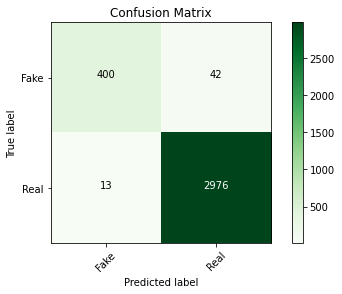

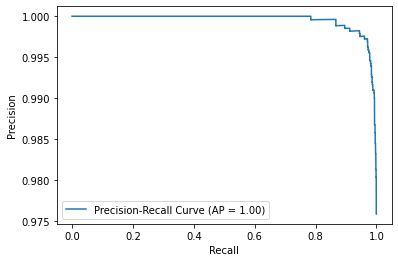

In [ ]:
# Passive Agressive Classifier
start = time.time()
linearclf = PassiveAggressiveClassifier(max_iter=10)

linearclf.fit(X_train, y_train)

y_pred = linearclf.predict(X_test)
end = time.time()
passive_time = end - start
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
passive_acc = round((100 * metrics.accuracy_score(y_test, y_pred)), 2)
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1-Score:", metrics.f1_score(y_test, y_pred))
print("Confusion Matrix:", metrics.confusion_matrix(y_test, y_pred))
cm = metrics.confusion_matrix(y_test, y_pred)
print(metrics.classification_report(y_test, y_pred))
passive_fp, passive_tp, thresh = roc_curve(y_test, y_pred)
plot_confusion_matrix(cm,classes = ['Fake','Real'])
#plot_confusion_matrix(linearclf, X_test, y_test, display_labels=['FAKE', 'REAL'], cmap='Greens', values_format="d")
plot_precision_recall_curve(linearclf, X_test, y_test, name='Precision-Recall Curve')

## Random Forest with TF-IDF

Accuracy: 0.9387933547070825
Precision: 0.9359899592092877
Recall: 0.9979926396788223
F1-Score: 0.9659974093264249
Confusion Matrix: [[ 238  204]
 [   6 2983]]
              precision    recall  f1-score   support

           0       0.98      0.54      0.69       442
           1       0.94      1.00      0.97      2989

    accuracy                           0.94      3431
   macro avg       0.96      0.77      0.83      3431
weighted avg       0.94      0.94      0.93      3431

CM not normalized


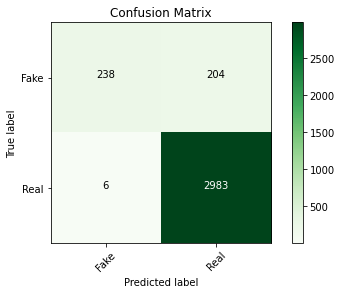

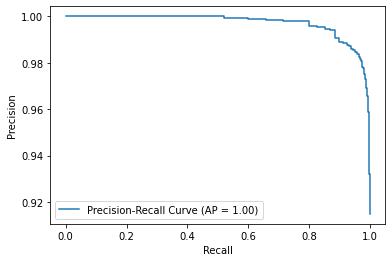

In [ ]:
# Random Forest Classifier
start = time.time()
forestclf = RandomForestClassifier(criterion='entropy', max_depth=400, random_state=0)

forestclf.fit(X_train, y_train)

y_pred = forestclf.predict(X_test)
end = time.time()
random_time = end - start
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
random_acc = round((100 * metrics.accuracy_score(y_test, y_pred)), 2)
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1-Score:", metrics.f1_score(y_test, y_pred))
print("Confusion Matrix:", metrics.confusion_matrix(y_test, y_pred))
cm = metrics.confusion_matrix(y_test, y_pred)
print(metrics.classification_report(y_test, y_pred))
random_fp, random_tp, thresh = roc_curve(y_test, y_pred)
plot_confusion_matrix(cm,classes = ['Fake','Real'])
#plot_confusion_matrix(forestclf, X_test, y_test, display_labels=['FAKE', 'REAL'], cmap='Greens', values_format="d")
plot_precision_recall_curve(forestclf, X_test, y_test, name='Precision-Recall Curve')

In [ ]:
# tune the hyperparameter alpha for the naive bayes classifier
#for depth in np.arange(10,200,10):
#    random_classifier_tune = RandomForestClassifier(criterion='entropy', max_depth=depth, random_state=0)
#    random_classifier_tune.fit(X_train, y_train)
#    pred_tune = random_classifier_tune.predict(X_test)
#    score = metrics.accuracy_score(y_test, pred_tune)
#    print("Alpha: {:.2f} Score: {:.5f}".format(depth, score))

## Neural Network with TF-IDF

Accuracy: 0.980763625765083
Precision: 0.9812314784326638
Recall: 0.9969889595182335
F1-Score: 0.9890474610023233
Confusion Matrix: [[ 385   57]
 [   9 2980]]
              precision    recall  f1-score   support

           0       0.98      0.87      0.92       442
           1       0.98      1.00      0.99      2989

    accuracy                           0.98      3431
   macro avg       0.98      0.93      0.96      3431
weighted avg       0.98      0.98      0.98      3431

CM not normalized


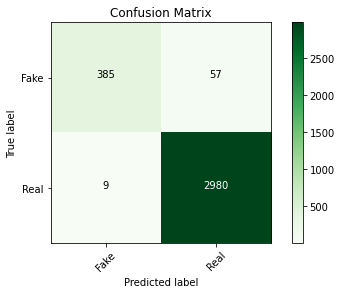

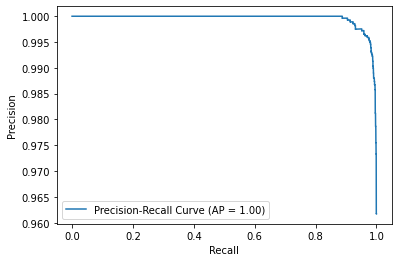

In [ ]:
#Neural Network MLP Classifier
start = time.time()
neuralclf=MLPClassifier(hidden_layer_sizes=(33,),max_iter=500)

neuralclf.fit(X_train, y_train)

y_pred = neuralclf.predict(X_test)
end = time.time()
nn_time = end - start
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
nn_acc = round((100 * metrics.accuracy_score(y_test, y_pred)), 2)
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1-Score:", metrics.f1_score(y_test, y_pred))
print("Confusion Matrix:", metrics.confusion_matrix(y_test, y_pred))
cm = metrics.confusion_matrix(y_test, y_pred)
print(metrics.classification_report(y_test, y_pred))
nn_fp, nn_tp, thresh = roc_curve(y_test, y_pred)
plot_confusion_matrix(cm,classes = ['Fake','Real'])
#plot_confusion_matrix(neuralclf, X_test, y_test, display_labels=['FAKE', 'REAL'], cmap='Greens', values_format="d")
plot_precision_recall_curve(neuralclf, X_test, y_test, name='Precision-Recall Curve')

## KNN with TF-IDF

Accuracy: 0.9271349460798601
Precision: 0.923338485316847
Recall: 0.9993308798929408
F1-Score: 0.9598329048843188
Confusion Matrix: [[ 194  248]
 [   2 2987]]
              precision    recall  f1-score   support

           0       0.99      0.44      0.61       442
           1       0.92      1.00      0.96      2989

    accuracy                           0.93      3431
   macro avg       0.96      0.72      0.78      3431
weighted avg       0.93      0.93      0.91      3431

CM not normalized


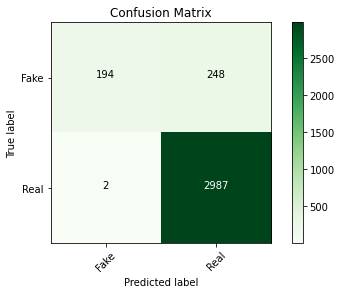

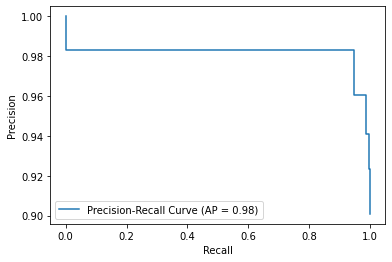

In [ ]:
# K-NearestNeighbour Classifier
start = time.time()
knnclf = KNeighborsClassifier(7)

knnclf.fit(X_train, y_train)

y_pred = knnclf.predict(X_test)
end = time.time()
knn_time = end - start
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
knn_acc = round((100 * metrics.accuracy_score(y_test, y_pred)), 2)
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1-Score:", metrics.f1_score(y_test, y_pred))
print("Confusion Matrix:", metrics.confusion_matrix(y_test, y_pred))
cm = metrics.confusion_matrix(y_test, y_pred)
print(metrics.classification_report(y_test, y_pred))
knn_fp, knn_tp, thresh = roc_curve(y_test, y_pred)
plot_confusion_matrix(cm,classes = ['Fake','Real'])
#plot_confusion_matrix(knnclf, X_test, y_test, display_labels=['FAKE', 'REAL'], cmap='Greens', values_format="d")
plot_precision_recall_curve(knnclf, X_test, y_test, name='Precision-Recall Curve')

## XGBoost Classifier With TF-IDF Vectorizer

Accuracy: 0.9522005246283882
Precision: 0.9528695094581596
Recall: 0.9943124790899966
F1-Score: 0.9731499672560576
Confusion Matrix: [[ 295  147]
 [  17 2972]]
              precision    recall  f1-score   support

           0       0.95      0.67      0.78       442
           1       0.95      0.99      0.97      2989

    accuracy                           0.95      3431
   macro avg       0.95      0.83      0.88      3431
weighted avg       0.95      0.95      0.95      3431

CM not normalized


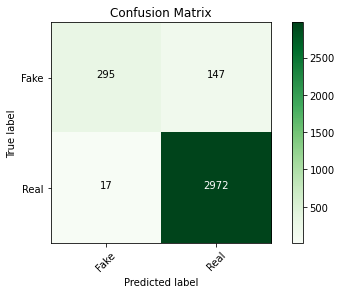

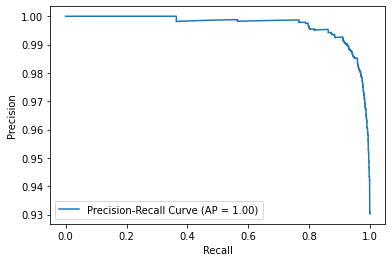

In [ ]:
# XGBoost Classifier
start = time.time()
xgbclf = XGBClassifier()

xgbclf.fit(X_train, y_train)

y_pred = xgbclf.predict(X_test)
end = time.time()
xgb_time = end - start
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
xgb_acc = round((100 * metrics.accuracy_score(y_test, y_pred)), 2)
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1-Score:", metrics.f1_score(y_test, y_pred))
print("Confusion Matrix:", metrics.confusion_matrix(y_test, y_pred))
cm = metrics.confusion_matrix(y_test, y_pred)
print(metrics.classification_report(y_test, y_pred))
xgb_fp, xgb_tp, thresh = roc_curve(y_test, y_pred)
plot_confusion_matrix(cm,classes = ['Fake','Real'])
#plot_confusion_matrix(xgbclf, X_test, y_test, display_labels=['FAKE', 'REAL'], cmap='Greens', values_format="d")
plot_precision_recall_curve(xgbclf, X_test, y_test, name='Precision-Recall Curve')

## CatBoost Classifier With TF-IDF Vectorizer 

Accuracy: 0.9641503934712912
Precision: 0.9631544925662573
Recall: 0.9969889595182335
F1-Score: 0.9797797139569293
Confusion Matrix: [[ 328  114]
 [   9 2980]]
              precision    recall  f1-score   support

           0       0.97      0.74      0.84       442
           1       0.96      1.00      0.98      2989

    accuracy                           0.96      3431
   macro avg       0.97      0.87      0.91      3431
weighted avg       0.96      0.96      0.96      3431

CM not normalized


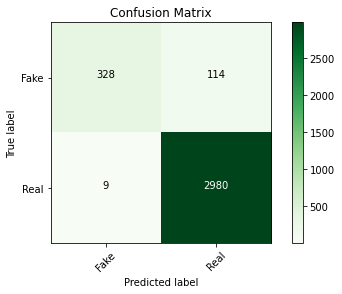

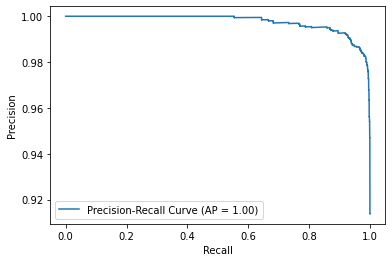

In [ ]:
#CatBoost Classifier
start = time.time()
catclf = CatBoostClassifier(verbose=0, n_estimators=100)

catclf.fit(X_train, y_train)

y_pred = catclf.predict(X_test)
end = time.time()
cat_time = end - start
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
cat_acc = round((100 * metrics.accuracy_score(y_test, y_pred)), 2)
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1-Score:", metrics.f1_score(y_test, y_pred))
print("Confusion Matrix:", metrics.confusion_matrix(y_test, y_pred))
cm = metrics.confusion_matrix(y_test, y_pred)
print(metrics.classification_report(y_test, y_pred))
cat_fp, cat_tp, thresh = roc_curve(y_test, y_pred)
plot_confusion_matrix(cm,classes = ['Fake','Real'])
#plot_confusion_matrix(catclf, X_test, y_test, display_labels=['FAKE', 'REAL'], cmap='Greens', values_format="d")
plot_precision_recall_curve(catclf, X_test, y_test, name='Precision-Recall Curve')

## AdaBoost Classifier With TF-IDF Vectorizer 

Accuracy: 0.9475371611774993
Precision: 0.9582381729200653
Recall: 0.9826028772164603
F1-Score: 0.9702675916749256
Confusion Matrix: [[ 314  128]
 [  52 2937]]
              precision    recall  f1-score   support

           0       0.86      0.71      0.78       442
           1       0.96      0.98      0.97      2989

    accuracy                           0.95      3431
   macro avg       0.91      0.85      0.87      3431
weighted avg       0.95      0.95      0.95      3431

CM not normalized


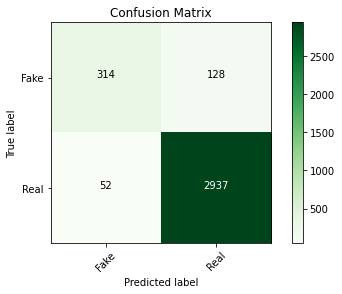

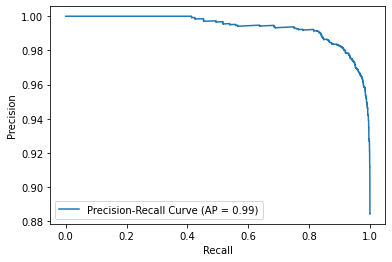

In [ ]:
# AdaBoost Classifier
start = time.time()
adaclf = AdaBoostClassifier()

adaclf.fit(X_train, y_train)

y_pred = adaclf.predict(X_test)
end = time.time()
ada_time = end - start
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
ada_acc = round((100 * metrics.accuracy_score(y_test, y_pred)), 2)
print("Precision:", metrics.precision_score(y_test, y_pred))
print("Recall:", metrics.recall_score(y_test, y_pred))
print("F1-Score:", metrics.f1_score(y_test, y_pred))
print("Confusion Matrix:", metrics.confusion_matrix(y_test, y_pred))
cm = metrics.confusion_matrix(y_test, y_pred)
print(metrics.classification_report(y_test, y_pred))
ada_fp, ada_tp, thresh = roc_curve(y_test, y_pred)
plot_confusion_matrix(cm,classes = ['Fake','Real'])
#plot_confusion_matrix(adaclf, X_test, y_test, display_labels=['FAKE', 'REAL'], cmap='Greens', values_format="d")
plot_precision_recall_curve(adaclf, X_test, y_test, name='Precision-Recall Curve')

## Plotting Barchart of the Model Accuracies

In [ ]:
accuracies={"SVM": svc_acc,
            "Logistic Regression": lr_acc,
            "MNB": mnb_acc,
            "Passive Agressive": passive_acc,
            "Random Forest": random_acc,
            "KNN": knn_acc,
            "Neural Network": nn_acc,
            "XGBoost": xgb_acc,
            "CatBoost": cat_acc,
            "AdaBoost": ada_acc}

acc_list=accuracies.items()
k,v = zip(*acc_list) 
temp=pd.DataFrame(index=k,data=v,columns=["Accuracy"])
temp.sort_values(by=["Accuracy"],ascending=False,inplace=True)

#Plot accuracy for different models
plt.figure(figsize=(20,7))
ACC=sns.barplot(y=temp.index,x=temp["Accuracy"],label="Accuracy",edgecolor="white",linewidth=3,orient="h",palette="twilight_r")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Comparison")
plt.xlim(95,100)

ACC.spines['left'].set_linewidth(3)
for w in ['right', 'top', 'bottom']:
    ACC.spines[w].set_visible(False)
    
#Write text on barplots
k=0
for ACC in ACC.patches:
    width = ACC.get_width()
    plt.text(width+0.1, (ACC.get_y() + ACC.get_height()-0.3),s="{}%".format(temp["Accuracy"][k]),fontname = 'monospace', fontsize = 14, color = 'black') 
    k+=1
    
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Plotting BarChart of Execution Time of the Models

In [ ]:
exe_time={"SVM": svc_time,
            "Logistic Regression": lr_time,
            "MNB": mnb_acc,
            "Passive Agressive": passive_time,
            "Random Forest": random_time,
            "KNN": knn_time,
            "Neural Network": nn_time,
            "XGBoost": xgb_time,
            "CatBoost": cat_time,
            "AdaBoost": ada_time}

time_list=exe_time.items()
k,v = zip(*time_list) 
temp1=pd.DataFrame(index=k,data=v,columns=["Time"])
temp1.sort_values(by=["Time"],ascending=False,inplace=True)

#Plot accuracy for different models
plt.figure(figsize=(20,7))
ET=sns.barplot(y=temp1.index,x=temp1["Time"],label="Time",edgecolor="white",linewidth=3,orient="h",palette="twilight_r")
plt.ylabel("Model")
plt.title("Execution Time Comparison")
ET.spines['left'].set_linewidth(3)
for w in ['right', 'top', 'bottom']:
    ET.spines[w].set_visible(False)

#Write text on barplots
k=0
for ET in ET.patches:
    width = ET.get_width()
    plt.text(width+0.01, (ET.get_y() + ET.get_height()-0.3),s="{}s".format(round((temp1["Time"][k]),3)),fontname = 'monospace', fontsize = 14, color = 'black') 
    k+=1

plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

## Plotting ROC Curves of the Models

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(sv_fp,sv_tp,'orange',label = 'SVM')
plt.plot(lr_fp,lr_tp,'red',label = 'Logistic Regression')
plt.plot(mnb_fp,mnb_tp,'purple',label = 'MNB')
plt.plot(passive_fp,passive_tp,'blue',label = 'Passive Agressive')
plt.plot(random_fp,random_tp,'yellow',label = 'Random Forests')
plt.plot(knn_fp,knn_tp,'brown',label = 'KNN')
plt.plot(nn_fp,nn_tp,'green',label = 'Neural Network')
plt.plot(xgb_fp,xgb_tp,'pink',label = 'XGBoost')
plt.plot(cat_fp,cat_tp,'magenta',label = 'CatBoost')
plt.plot(ada_fp,ada_tp,'cyan',label = 'AdaBoost')

plt.legend("SVM", loc='lower right')
plt.legend("Logistic Regression", loc='lower right')
plt.legend("MNB", loc='lower right')
plt.legend("Passive Agressive", loc='lower right')
plt.legend("Random Forests", loc='lower right')
plt.legend("KNN", loc='lower right')
plt.legend("Neural Network", loc='lower right')
plt.legend("XGBoost", loc='lower right')
plt.legend("CatBoost", loc='lower right')
plt.legend("AdaBoost", loc='lower right')
plt.legend(loc='lower right')

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title('ROC Curve of The Models')
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(sv_fp,sv_tp,'orange',label = 'SVM')
plt.plot(lr_fp,lr_tp,'red',label = 'Logistic Regression')
plt.plot(mnb_fp,mnb_tp,'purple',label = 'MNB')
plt.plot(random_fp,random_tp,'yellow',label = 'Random Forests')
plt.plot(knn_fp,knn_tp,'brown',label = 'KNN')
plt.plot(ada_fp,ada_tp,'cyan',label = 'AdaBoost')

plt.legend("SVM", loc='lower right')
plt.legend("Logistic Regression", loc='lower right')
plt.legend("MNB", loc='lower right')
plt.legend("Random Forests", loc='lower right')
plt.legend("KNN", loc='lower right')
plt.legend("AdaBoost", loc='lower right')
plt.legend(loc='lower right')

plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title('ROC Curve of The Models')
plt.show()